In [66]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib_inline
import seaborn as sns
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import copy

In [67]:
url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep = ';')
data = (data - data.mean())/data.std(ddof = 1)

dataOrig = copy.deepcopy( data )


In [68]:
n2nan = 10

# randomly choosing 10 rows from the data and replace their residual values with nan
whichVals2nan = np.random.choice(len(data), size = n2nan, replace = False)


# replace it with nan 
data.loc[whichVals2nan, 'residual sugar'] = np.nan


whichValsNotNan = np.where(~data['residual sugar'].isna())[0]



In [69]:
# converting the dataframe into tensor 
cols2keep = data.keys()
cols2keep = cols2keep.drop('residual sugar')


train_data = torch.tensor(data[cols2keep].values).float()
train_data = train_data[whichValsNotNan ,:]
train_labels = torch.tensor(data['residual sugar'].values).float()
train_labels =  train_labels[whichValsNotNan, None]

test_data = torch.tensor(data[cols2keep].values).float()
test_data = test_data[whichVals2nan, :]
test_labels = torch.tensor(dataOrig['residual sugar'].values).float()
test_labels =  test_labels[whichVals2nan, None]

In [70]:
print(f'Original data: {data.shape}\n')
print(f'   Train data: {train_data.shape}\n')
print(f' Train labels: {train_labels.shape}\n')
print(f'    Test data: {test_data.shape}\n')
print(f'  Test labels: {test_labels.shape}')

Original data: (1599, 12)

   Train data: torch.Size([1589, 11])

 Train labels: torch.Size([1589, 1])

    Test data: torch.Size([10, 11])

  Test labels: torch.Size([10, 1])


In [71]:
# then convert them into PyTorch Dataset
train_Dataset = TensorDataset(train_data,train_labels)

# finally, translate into dataloader objects
batchsize  = 32
train_loader = DataLoader(train_Dataset,batch_size=batchsize,shuffle=True,drop_last=True)


In [72]:

def createNeuralNet():

    class ANNwine(nn.Module):

        def __init__(self):

            super().__init__()

            # input layer 
            self.input = nn.Linear(11, 64)

            # hidden layers 
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 16)
        
            # output layer 
            self.output = nn.Linear(16, 1)

        def forward(self, X):

            X = F.relu(self.input(X))
            X = F.relu(self.fc1(X))
            X = F.relu(self.fc2(X))

            return self.output(X)

    net = ANNwine()

    # loss function
    lossfun = nn.MSELoss()

    # optimizer 
    optimizer = torch.optim.Adam(net.parameters(), lr = .001) 

    return net, lossfun, optimizer



In [73]:
def trainTheModel():

    numepochs = 100

    net, lossfun, optimizer = createNeuralNet()

    losses = np.zeros(numepochs)

    
    for epochi in range(numepochs):

        batchLoss = []

        for X, y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            batchLoss.append(loss.item())
        
        losses[epochi] = np.mean(batchLoss)

    return losses, net



In [82]:
trainlosses, net = trainTheModel()

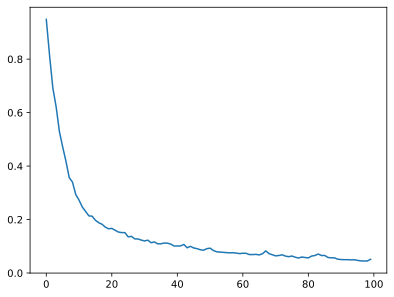

In [83]:
plt.plot(losses)

In [84]:
# get the predictions for the missing data
yHatTrain = net(train_data)
yHatTest  = net(test_data)

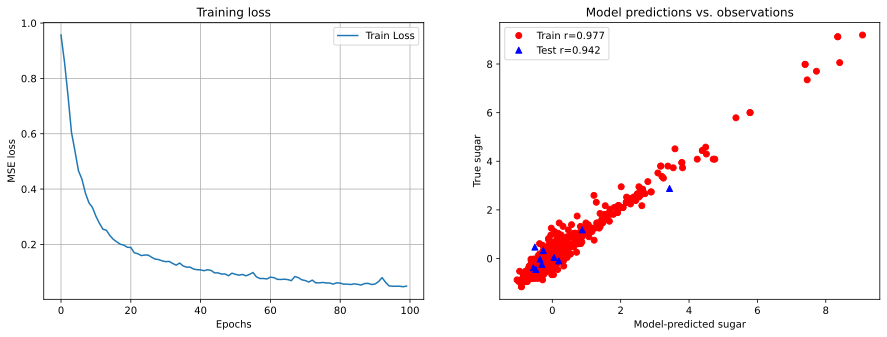

In [86]:

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(trainlosses, label = 'Train Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('MSE loss')
ax[0].set_title('Training loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(yHatTrain.detach(), train_labels, 'ro')
ax[1].plot(yHatTest.detach(), test_labels, 'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')


## correlation 
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labels.T)[0,1]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labels.T)[0,1]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()